In [1]:
%pip install yfinance --upgrade --no-cache-dir
%pip install nltk --upgrade --no-cache-dir
%pip install scikit-learn --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing necessary libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import *
from keras.layers import add
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
import nltk

nltk.download('stopwords')

2024-07-02 19:55:06.885565: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 19:55:06.930578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 19:55:06.930620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 19:55:06.931975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 19:55:06.940461: I tensorflow/core/platform/cpu_feature_guar

True

### Downloading data between 2010 & 2020 from yahoo finance API

In [3]:
# Define the ticker symbol for S&P BSE SENSEX
ticker_symbol = "^BSESN"

# Download the data
data = yf.download(ticker_symbol, start="2001-01-01", end="2020-12-31")

# Display the first few rows of the data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


### Loading news headlines

In [4]:
news = pd.read_csv('india-news-headlines.csv')

In [5]:
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [6]:
# Convert the 'publish_date' column to datetime
news['publish_date'] = pd.to_datetime(news['publish_date'], format='%Y%m%d')

In [7]:
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [8]:
# Dropping the headline category
news.drop(['headline_category'], axis=1, inplace=True)

In [9]:
news.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


### EDA

In [10]:
print(data.shape)
print(news.shape)

(4926, 6)
(3650970, 2)


In [11]:
data = data.reset_index()

In [12]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [13]:
# Compare the number of unique dates. We want matching values.
print(len(set(data.Date)))
print(len(set(news.publish_date)))

4926
7717


In [14]:
# Remove the extra dates that are in data
data = data[data.Date.isin(news.publish_date)]

In [15]:
print(len(set(data.Date)))
print(len(set(news.publish_date)))

4897
7717


In [16]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
data = data.set_index('Date').diff(periods=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
# Remove unneeded features
data = data.drop(['High','Low','Close','Volume','Adj Close'], axis= 1)

In [17]:
data.head()

,Open,Date
0,NaN,2001-01-02
1,24.360107,2001-01-03
2,203.390137,2001-01-04
3,-64.630371,2001-01-05
4,48.419922,2001-01-08


In [18]:
# dRopping null values
data.dropna(inplace=True)

In [19]:
# Check if there are any more null values.
data.isnull().sum()

Open    0
Date    0
dtype: int64

In [20]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in data.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.publish_date==date].iterrows():
        daily_headlines.append(row_[1]['headline_text'])

    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500
2000
2500
3000
3500
4000
4500


In [21]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))


# Calculate the number of headlines for each day
headline_counts = [len(day) for day in headlines]

# Calculate the mean number of headlines per day
mean_headlines = sum(headline_counts) / len(headline_counts)

# Print the mean number of headlines per day
print(mean_headlines)

706
1
476.7542892156863


In [22]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [23]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'0,0', '00', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)

    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [24]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [25]:
# Take a look at some headlines to ensure everything was cleaned well
clean_headlines[0]

['powerless north india gropes dark',
 'think laxman tells sangh parivar',
 'hurriyat undecided team pakistan',
 'vajpayee wants put reforms fast track',
 'stephen hawking keeps date mumbai',
 'anti hrithik anti hopelessness',
 'govt plans stadium near panaji',
 'bjp volte face casinos cong',
 '3 watershed projects anvil',
 'report yet fire udyog bhavan',
 'king five star industry',
 'petrol pump sealed selling adulterated fuel',
 'milk price rs 1 per litre',
 'congress house smoking zone',
 'rural weightage govt reassures governor',
 'bride gets honeymoon surprise chopper ride',
 'hangover sign alcoholicism',
 'almatti ap wait watch',
 '10 year old girl missing',
 'hear messages heart',
 'dance like one watching',
 'reel love real love',
 'power row bribe attempt charge denied',
 'lakshamma cry help heard',
 'shopping time newborn',
 'con games catwalk',
 'help us',
 'noisy spots hurting ears',
 'flat tyres flat music famous faces',
 'yogananda birth anniversary fete dec 5',
 'tumkur 

In [26]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1

print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 179346


In [27]:
import numpy as np
import csv
from tqdm import tqdm

def load_embeddings(file_path):
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.replace('\x00', '')  # Remove null characters
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            yield word, embedding

embeddings_index = {}
for word, embedding in tqdm(load_embeddings('glove.840B.300d.txt'), desc="Processing GloVe embeddings"):
    embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))


Processing GloVe embeddings: 1152987it [01:45, 10923.72it/s]


Word embeddings: 1152986


In [28]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 10561
Percent of words that are missing from vocabulary: 5.89%


In [29]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 179346
Number of Words we will use: 87336
Percent of Words we will use: 48.699999999999996%


In [30]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

87336


##### Note: The embeddings will be updated as the model trains, so our new 'random' embeddings will be more accurate by the end of training. This is also why we want to only use words that appear at least 5 times. By having the model see the word numerous times it will be better able to understand what it means.

In [31]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 13968945
Total number of UNKs in headlines: 175981
Percent of words that are UNK: 1.26%


In [32]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [33]:
lengths.describe()

,counts
count,2.334189e+06
mean,5.984496e+00
std,2.101246e+00
min,0.000000e+00
25%,5.000000e+00
50%,6.000000e+00
75%,7.000000e+00
max,2.200000e+01


In [34]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [35]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [36]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [37]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5549642121685825


In [38]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [39]:
# Check the lengths
print(len(x_train))
print(len(x_test))

4161
735


In [40]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2


def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    ####

    model2 = Sequential()
    
    model2.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model2.add(Dropout(dropout))
    
    
    model2.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length2, 
                             padding = 'same',
                             activation = 'relu'))
    model2.add(Dropout(dropout))
    
    if deeper == True:
        model2.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length2, 
                                 padding = 'same',
                                 activation = 'relu'))
        model2.add(Dropout(dropout))
    
    model2.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))
    
    ####

    model = Sequential()

    model = add([model1.output, model2.output])
    model = Dense(hidden_dims, kernel_initializer=weights)(model)
    model = Dropout(dropout)(model)
    if deeper == True:
        model = Dense(hidden_dims//2, kernel_initializer=weights)(model)
        model = Dropout(dropout)(model)
    model = Dense(1, kernel_initializer = weights, name='output')(model)
    new_model = Model([model1.input, model2.input], model)
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate, clipvalue=1.0))
    return new_model

In [41]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)

2024-07-02 20:04:01.042177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Epoch 1/100
28/28 [==============================] - 42s 1s/step - loss: 0.4393 - val_loss: 0.0405 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 38s 1s/step - loss: 0.0320 - val_loss: 0.0171 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 38s 1s/step - loss: 0.0220 - val_loss: 0.0107 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 38s 1s/step - loss: 0.0190 - val_loss: 0.0102 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 38s 1s/step - loss: 0.0164 - val_loss: 0.0082 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 39s 1s/step - loss: 0.0144 - val_loss: 0.0060 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 38s 1s/step - loss: 0.0132 - val_l

In [42]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

23/23 [==============================] - 2s 94ms/step


In [43]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.001899653394494193

In [44]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [45]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [46]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

146.48779296874955

In [47]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

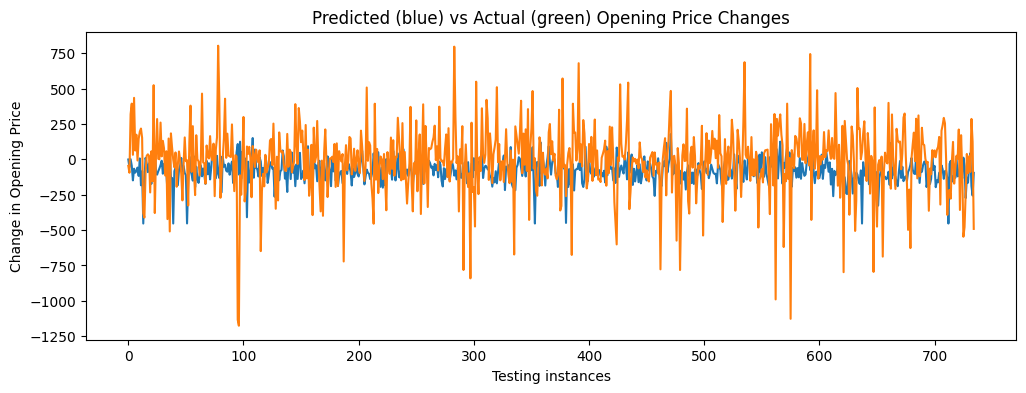

In [48]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [49]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [50]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))